# Model Prep

In [40]:
import pandas as pd

In [41]:
df=pd.read_csv("/product_matcher/data/fe_data.csv")

In [42]:
!pip install lightgbm

In [43]:
#more trials

In [44]:
from rapidfuzz import fuzz
import numpy as np

def enrich_features(df):
    # pn_exact if missing
    if "pn_exact" not in df.columns:
        df["pn_exact"] = (df["client_part_number"].fillna("").str.upper().str.replace(r"[-_/.\s]","",regex=True) ==
                          df["page_part_number"].fillna("").str.upper().str.replace(r"[-_/.\s]","",regex=True)).astype(int)

    # pn_sim if missing
    if "pn_sim" not in df.columns:
        df["pn_sim"] = df.apply(lambda r: fuzz.ratio(str(r.client_part_number), str(r.page_part_number))/100, axis=1)

    # pn_prefix_match if missing
    if "pn_prefix_match" not in df.columns:
        df["pn_prefix_match"] = df.apply(lambda r: int(str(r.client_part_number)[:4] == str(r.page_part_number)[:4]), axis=1)

    # manu_sim if missing
    if "manu_sim" not in df.columns:
        df["manu_sim"] = df.apply(lambda r: fuzz.ratio(str(r.client_part_manufacturer), str(r.page_part_manufacturer))/100, axis=1)

    # group_jaccard if missing
    if "group_jaccard" not in df.columns:
        df["group_jaccard"] = df.apply(
            lambda r: len(set(str(r.client_part_product_group).split()) & set(str(r.page_part_product_group).split())) /
                      (len(set(str(r.client_part_product_group).split()) | set(str(r.page_part_product_group).split())) + 1e-6),
            axis=1
        )

    # price_ratio if missing
    if "price_ratio" not in df.columns:
        df["price_ratio"] = df.apply(
            lambda r: r.client_part_price / r.page_part_price if r.page_part_price and r.client_part_price else 0,
            axis=1
        )
        df["price_ratio"] = df["price_ratio"].clip(0, 10)

    # pn_len_diff if missing
    if "pn_len_diff" not in df.columns:
        df["pn_len_diff"] = abs(df["client_pn_len"] - df["page_pn_len"])

    return df

In [45]:
df_enriched=enrich_features(df)

In [46]:
df_enriched

,page_part_title,page_part_number,page_part_description,page_part_product_group,page_part_manufacturer,client_part_manufacturer,client_part_number,client_part_type,client_part_internal_number,client_part_product_group,...,pn_in_text,client_pn_len,page_pn_len,pn_exact,pn_sim,pn_prefix_match,manu_sim,group_jaccard,price_ratio,pn_len_diff
0,SMC-VENTILE AN120-X200 (NAN) SCHALLDÄMPFER,NOPARTNUMBER,UNKNOWN,UNKNOWN,SMC-VENTILE SMC-VENTILE AN120-X200 (NAN) SCHAL...,ELGES,GELENKKOPFD2520M16X15,UNKNOWN,00-0100-04-45-08,WÄLZLAGERZUBEHÖR,...,0,21,12,0,0.242424,0,0.135593,0.0,5.557503,9
1,MERIT MESSING 04601-20,0460120,Produktinformationen:\n\nUPC671404080099,HOME,MERIT BRASS,Roemheld Group,04601020,4601020,3715418,GRUPPE1,...,0,8,7,0,0.933333,1,0.160000,0.0,7.754017,1
2,Zahnriemen zöllig 390 H 100 78 Zähne Wirklänge...,390H100ZAHNRIEMENZÖLLIG390H10078ZÄHNEWIRKLÄNGE...,UNKNOWN,UNKNOWN,Zahnriemen zöllig 390 H 100 78 Zähne Wirklänge...,HERKT,390H100,UNKNOWN,279735600000,EA,...,1,7,53,0,0.233333,1,0.125000,0.0,0.467973,46
3,Siemens Indus.Sector Leistungsschalter 3RV2021...,3RV20214DA25,UNKNOWN,UNKNOWN,Siemens Indus.Sector,SIEMENS AG,3RV20214DA25,UNKNOWN,99-0650-38-00-73,SCHALTGERÄTE,...,1,12,12,1,1.000000,1,0.200000,0.0,0.771100,0
4,M10 DIN 603 Stahl A2 Edelstahl Flachrundschrau...,M10DIN603STAHLA2EDELSTAHLFLACHRUNDSCHRAUBENMIT...,DIN 603 Stahl A2 Edelstähle Flachrundschrauben...,UNKNOWN,M10 DIN 603 Stahl A2 Edelstahl Flachrundschrau...,Seifert Drucklufttechnik GmbH,11180926204ES,"1/2"" EDELSTAHL",2910362,ROHRLEITUNGSTECHNIK,...,1,13,60,0,0.164384,0,0.257426,0.0,0.588235,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Original moloco b12 box,ORIGINALMOLOCOB12BOX,barang ready stok silahkan di order langsung b...,OBATALERGISINUSATSHMA,Original moloco b12 box,INA,KB12PP,UNKNOWN,683808100001,E4,...,1,6,20,0,0.230769,0,0.206897,0.0,0.769390,14
4996,"Kermi L-KON S Typ33 BH140x194x3000mm AB U, m. ...",KERMILKONSTYP33BH140X194X3000MMABUMABDECKUNGQN...,"Kermi L-KON S Typ33 BH140x194x3000mm AB U, m. ...",UNKNOWN,"Kermi L-KON S Typ33 BH140x194x3000mm AB U, m. ...",Fricke und Mallah,94X34X301,UNKNOWN,00-0100-12-16-53,ERSATZTEILEPAKETE,...,1,9,72,0,0.197531,0,0.135922,0.0,0.109041,63
4997,Gummidichtung für Staubsaugerbeutel Vorwerk Ko...,EPA888100812,"Neuware, originalverpackt\nKein Originalproduk...",UNKNOWN,AccuCell,SKODOCK,DICHTUNG40572,UNKNOWN,99-0300-77-55-00,DICHTUNGEN,...,0,13,12,0,0.160000,0,0.133333,0.0,0.897611,1
4998,Arduino Nano 3.0 (A000005) | ARDUINO,ARDUINONANO30(A000005),Arduino Nano 3.0 (A000005) ARDUINO - Entwicklu...,MAKERBOARDSFÜRENTWICKLUNGTESTODERBILDUNG,ARDUINO,SKF,SY20TF,UNKNOWN,00-0100-02-40-69,SONDERLAGER,...,1,6,22,0,0.071429,0,0.000000,0.0,2.047643,16


In [47]:
# 1. Apply hard rules
def apply_hard_rules(row):
    # Hard match
    if row["client_part_number"] == row["page_part_number"] and row["manu_first_match"] == 1:
        return 1, "rule_pn_brand_exact"
    # Hard non-match
    if row["manu_first_match"] == 0 and row["price_diff_rel"] > 0.95:
        return 0, "rule_brand_conflict_price_far"
    return None, None



In [48]:
decisions, reasons = [], []
for _, r in df_enriched.iterrows():
    d, why = apply_hard_rules(r)
    decisions.append(d)
    reasons.append(why)

df_enriched["hard_decision"] = decisions
df_enriched["hard_reason"]   = reasons

# 2. Split into: rule_decided vs undecided
df_rules = df[df["hard_decision"].notna()]   # already decided
df_ml    = df[df["hard_decision"].isna()] 

In [49]:
df_rules

,page_part_title,page_part_number,page_part_description,page_part_product_group,page_part_manufacturer,client_part_manufacturer,client_part_number,client_part_type,client_part_internal_number,client_part_product_group,...,page_pn_len,pn_exact,pn_sim,pn_prefix_match,manu_sim,group_jaccard,price_ratio,pn_len_diff,hard_decision,hard_reason
3,Siemens Indus.Sector Leistungsschalter 3RV2021...,3RV20214DA25,UNKNOWN,UNKNOWN,Siemens Indus.Sector,SIEMENS AG,3RV20214DA25,UNKNOWN,99-0650-38-00-73,SCHALTGERÄTE,...,12,1,1.000000,1,0.200000,0.0,0.771100,0,1.0,rule_pn_brand_exact
10,FAG Rillenkugellager 6030 | Rollerbearings,RILLENKUGELLAGER6030,FAG Rillenkugellager 6030Hersteller: FAGProduk...,WÄLZLAGERKUGELLAGER,FAG,Inline Hydraulik GmbH,6030961100,Großer Anschluss,0006654,WARENGRUPPE1KANNEG,...,20,0,0.266667,0,0.071429,0.0,0.049454,10,0.0,rule_brand_conflict_price_far
11,VIBRA SENSE2 CLICK MIKROELEKTRONIKA - Click bo...,VIBRASENSE2CLICK,Hersteller: MIKROELEKTRONIKA | Entwicklungsbo...,ENTWICKLUNGSBOARDSERWEITERUNGSBOARDS,MIKROELEKTRONIKA,SuSTEK GmbH,BRA55,UNKNOWN,004994007,4284,...,16,0,0.285714,0,0.148148,0.0,10.000000,11,0.0,rule_brand_conflict_price_far
12,WAGO 2002-402 Kammbrücker 2fach grau,2002402,Kammbrücker isoliert 2-fach Nennstrom 25 A lic...,INSTALLATIONDOSENKÄSTENKLEMMEN,WAGO,Motec GmbH,4020021002,Systemkabel MKS10 10m,2478053,KLEINELEKTRO,...,7,0,0.705882,0,0.142857,0.0,10.000000,3,0.0,rule_brand_conflict_price_far
21,"7026874 SEAL, FUEL PUMP",7026874,7026874 Click here to find the location of thi...,JLGPARTS,JLG Parts,SMC Deutschland GmbH,26874,KD.20X35 CQ2B20-35D,3673423,LINEARTECHNIK,...,7,0,0.833333,0,0.181818,0.0,10.000000,2,0.0,rule_brand_conflict_price_far
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,"Sensor,ind.,M12x1 1S,f.:400Hz,DC,IP67 IF5579",IF5579,Breite des Sensors: 17 mm | Höhe des Sensors:...,NIEDERSPANNUNGSSCHALTTECHNIKNÄHERUNGSSCHALTERN...,ifm electronic,IFM ELECTRONIC,IF5579,IF5579,53954356,E35SENSORSANDMEASURINGUNITS,...,6,1,1.000000,1,0.000000,0.0,0.559228,0,1.0,rule_pn_brand_exact
4991,FESTO 559289 DSNU-25-200-PPS-A Normzylinder H...,559289,Technische Daten\n \n Artik...,PNEUMATIKZYLINDER&PNEUMATISCHEANTRIEBEKOLBENST...,FESTO,Festo Vertrieb GmbH & Co. KG,559289,DSNU-25-200-PPS-A,0558023,LINEARTECHNIK,...,6,1,1.000000,1,0.058824,0.0,0.866453,0,1.0,rule_pn_brand_exact
4993,"GN 256 Silikon-Anschlagpuffer Kegelstumpfform,...",GN25619M555BL,UNKNOWN,UNKNOWN,Ganter Normelemente,HAWE,7501010100,UNKNOWN,99-0600-33-16-00,VENTILEÖLHYDRAULIK,...,13,0,0.173913,0,0.000000,0.0,10.000000,3,0.0,rule_brand_conflict_price_far
4994,Profitec HDMI Kabel 1.4 Vollmetallstecker 19 p...,PROFITECHDMIKABEL14VOLLMETALLSTECKER19PLIGAUF1...,Jetzt preiswert Profitec HDMI Kabel 1.4 Vollme...,LIFESTORE,PROFITEC,Interroll Foerdertechnik,MIDMI,"BLANK 0,37KW,V=0,81M/S",4621413,ELEKTRISCHERANTRIEB,...,82,0,0.091954,0,0.054054,0.0,10.000000,77,0.0,rule_brand_conflict_price_far


In [50]:
df_ml['hard_decision']='NA'
df_ml['hard_reason']='NA'

/var/folders/9h/dq07x5r50wqd4360627fl7q40000gn/T/ipykernel_79527/1356476607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['hard_decision']='NA'
/var/folders/9h/dq07x5r50wqd4360627fl7q40000gn/T/ipykernel_79527/1356476607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['hard_reason']='NA'


In [51]:
features = [
    "group_exact", "manu_first_match", "manu_in_text", "pn_in_text",
    "client_part_price", "page_part_price", "price_diff_abs", "price_diff_rel",
    "client_pn_len", "page_pn_len", "pn_len_diff",
    "pn_exact", "pn_sim", "pn_prefix_match",
    "manu_sim", "group_jaccard", "price_ratio"
]

In [52]:
#3269-df_ml
#1731-df_rules

In [53]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# enrich dataset
#df = enrich_features(df)

X = df_ml[features]
y = df_ml["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.05,
    num_leaves=63,
    n_estimators=500,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight="balanced",
    random_state=42
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)


y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 499, number of negative: 2116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 2615, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.92735	valid_0's binary_logloss: 0.297587
[100]	valid_0's auc: 0.934019	valid_0's binary_logloss: 0.272508
[150]	valid_0's auc: 0.935713	valid_0's binary_logloss: 0.284676
Early stopping, best iteration is:
[104]	valid_0's auc: 0.934775	valid_0's binary_logloss: 0.271065
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       529
           1       0.71      0.76      0.74    

In [54]:
X_test.columns

Index(['group_exact', 'manu_first_match', 'manu_in_text', 'pn_in_text',
       'client_part_price', 'page_part_price', 'price_diff_abs',
       'price_diff_rel', 'client_pn_len', 'page_pn_len', 'pn_len_diff',
       'pn_exact', 'pn_sim', 'pn_prefix_match', 'manu_sim', 'group_jaccard',
       'price_ratio'],
      dtype='object')

In [56]:
#2615-X_train
#654-X_test

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

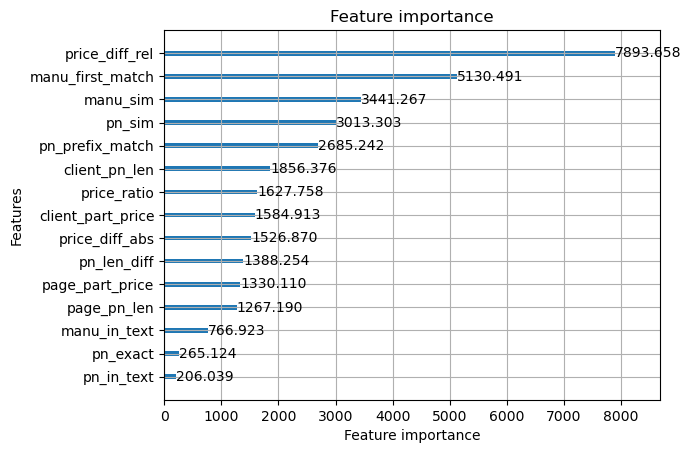

In [57]:
lgb.plot_importance(clf, importance_type="gain", max_num_features=15)

In [58]:
results_test = df_ml.loc[X_test.index].copy()
results_test["true_label"] = y_test.values
results_test["pred_label"] = y_pred
results_test["pred_proba"] = y_proba
results_test["source"] = "test"

In [59]:
y_pred_train = clf.predict(X_train)
y_proba_train = clf.predict_proba(X_train)[:,1]

results_train = df_ml.loc[X_train.index].copy()
results_train["true_label"] = y_train.values
results_train["pred_label"] = y_pred_train
results_train["pred_proba"] = y_proba_train
results_train["source"] = "train"

In [60]:
results_all = pd.concat([results_train, results_test])

In [61]:
results_all.columns

Index(['page_part_title', 'page_part_number', 'page_part_description',
       'page_part_product_group', 'page_part_manufacturer',
       'client_part_manufacturer', 'client_part_number', 'client_part_type',
       'client_part_internal_number', 'client_part_product_group',
       'client_part_price', 'page_part_price', 'label', 'group_exact',
       'client_manu_first', 'page_manu_first', 'manu_first_match',
       'price_diff_abs', 'price_diff_rel', 'manu_in_text', 'pn_in_text',
       'client_pn_len', 'page_pn_len', 'pn_exact', 'pn_sim', 'pn_prefix_match',
       'manu_sim', 'group_jaccard', 'price_ratio', 'pn_len_diff',
       'hard_decision', 'hard_reason', 'true_label', 'pred_label',
       'pred_proba', 'source'],
      dtype='object')

In [62]:
df_rules.columns

Index(['page_part_title', 'page_part_number', 'page_part_description',
       'page_part_product_group', 'page_part_manufacturer',
       'client_part_manufacturer', 'client_part_number', 'client_part_type',
       'client_part_internal_number', 'client_part_product_group',
       'client_part_price', 'page_part_price', 'label', 'group_exact',
       'client_manu_first', 'page_manu_first', 'manu_first_match',
       'price_diff_abs', 'price_diff_rel', 'manu_in_text', 'pn_in_text',
       'client_pn_len', 'page_pn_len', 'pn_exact', 'pn_sim', 'pn_prefix_match',
       'manu_sim', 'group_jaccard', 'price_ratio', 'pn_len_diff',
       'hard_decision', 'hard_reason'],
      dtype='object')

In [63]:
df_rules['source']='hard_rules'
df_rules["true_label"] = df_rules['hard_decision'].astype(int)
df_rules["pred_label"] = 'NA'
df_rules["pred_proba"] = 'NA'


/var/folders/9h/dq07x5r50wqd4360627fl7q40000gn/T/ipykernel_79527/920399936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules['source']='hard_rules'
/var/folders/9h/dq07x5r50wqd4360627fl7q40000gn/T/ipykernel_79527/920399936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules["true_label"] = df_rules['hard_decision'].astype(int)
/var/folders/9h/dq07x5r50wqd4360627fl7q40000gn/T/ipykernel_79527/920399936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [64]:
df_rules.columns
#results_final = results_all.join(df_ml.loc[X_test.index, cols_to_keep])

Index(['page_part_title', 'page_part_number', 'page_part_description',
       'page_part_product_group', 'page_part_manufacturer',
       'client_part_manufacturer', 'client_part_number', 'client_part_type',
       'client_part_internal_number', 'client_part_product_group',
       'client_part_price', 'page_part_price', 'label', 'group_exact',
       'client_manu_first', 'page_manu_first', 'manu_first_match',
       'price_diff_abs', 'price_diff_rel', 'manu_in_text', 'pn_in_text',
       'client_pn_len', 'page_pn_len', 'pn_exact', 'pn_sim', 'pn_prefix_match',
       'manu_sim', 'group_jaccard', 'price_ratio', 'pn_len_diff',
       'hard_decision', 'hard_reason', 'source', 'true_label', 'pred_label',
       'pred_proba'],
      dtype='object')

In [65]:
df_rules

,page_part_title,page_part_number,page_part_description,page_part_product_group,page_part_manufacturer,client_part_manufacturer,client_part_number,client_part_type,client_part_internal_number,client_part_product_group,...,manu_sim,group_jaccard,price_ratio,pn_len_diff,hard_decision,hard_reason,source,true_label,pred_label,pred_proba
3,Siemens Indus.Sector Leistungsschalter 3RV2021...,3RV20214DA25,UNKNOWN,UNKNOWN,Siemens Indus.Sector,SIEMENS AG,3RV20214DA25,UNKNOWN,99-0650-38-00-73,SCHALTGERÄTE,...,0.200000,0.0,0.771100,0,1.0,rule_pn_brand_exact,hard_rules,1,NA,NA
10,FAG Rillenkugellager 6030 | Rollerbearings,RILLENKUGELLAGER6030,FAG Rillenkugellager 6030Hersteller: FAGProduk...,WÄLZLAGERKUGELLAGER,FAG,Inline Hydraulik GmbH,6030961100,Großer Anschluss,0006654,WARENGRUPPE1KANNEG,...,0.071429,0.0,0.049454,10,0.0,rule_brand_conflict_price_far,hard_rules,0,NA,NA
11,VIBRA SENSE2 CLICK MIKROELEKTRONIKA - Click bo...,VIBRASENSE2CLICK,Hersteller: MIKROELEKTRONIKA | Entwicklungsbo...,ENTWICKLUNGSBOARDSERWEITERUNGSBOARDS,MIKROELEKTRONIKA,SuSTEK GmbH,BRA55,UNKNOWN,004994007,4284,...,0.148148,0.0,10.000000,11,0.0,rule_brand_conflict_price_far,hard_rules,0,NA,NA
12,WAGO 2002-402 Kammbrücker 2fach grau,2002402,Kammbrücker isoliert 2-fach Nennstrom 25 A lic...,INSTALLATIONDOSENKÄSTENKLEMMEN,WAGO,Motec GmbH,4020021002,Systemkabel MKS10 10m,2478053,KLEINELEKTRO,...,0.142857,0.0,10.000000,3,0.0,rule_brand_conflict_price_far,hard_rules,0,NA,NA
21,"7026874 SEAL, FUEL PUMP",7026874,7026874 Click here to find the location of thi...,JLGPARTS,JLG Parts,SMC Deutschland GmbH,26874,KD.20X35 CQ2B20-35D,3673423,LINEARTECHNIK,...,0.181818,0.0,10.000000,2,0.0,rule_brand_conflict_price_far,hard_rules,0,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,"Sensor,ind.,M12x1 1S,f.:400Hz,DC,IP67 IF5579",IF5579,Breite des Sensors: 17 mm | Höhe des Sensors:...,NIEDERSPANNUNGSSCHALTTECHNIKNÄHERUNGSSCHALTERN...,ifm electronic,IFM ELECTRONIC,IF5579,IF5579,53954356,E35SENSORSANDMEASURINGUNITS,...,0.000000,0.0,0.559228,0,1.0,rule_pn_brand_exact,hard_rules,1,NA,NA
4991,FESTO 559289 DSNU-25-200-PPS-A Normzylinder H...,559289,Technische Daten\n \n Artik...,PNEUMATIKZYLINDER&PNEUMATISCHEANTRIEBEKOLBENST...,FESTO,Festo Vertrieb GmbH & Co. KG,559289,DSNU-25-200-PPS-A,0558023,LINEARTECHNIK,...,0.058824,0.0,0.866453,0,1.0,rule_pn_brand_exact,hard_rules,1,NA,NA
4993,"GN 256 Silikon-Anschlagpuffer Kegelstumpfform,...",GN25619M555BL,UNKNOWN,UNKNOWN,Ganter Normelemente,HAWE,7501010100,UNKNOWN,99-0600-33-16-00,VENTILEÖLHYDRAULIK,...,0.000000,0.0,10.000000,3,0.0,rule_brand_conflict_price_far,hard_rules,0,NA,NA
4994,Profitec HDMI Kabel 1.4 Vollmetallstecker 19 p...,PROFITECHDMIKABEL14VOLLMETALLSTECKER19PLIGAUF1...,Jetzt preiswert Profitec HDMI Kabel 1.4 Vollme...,LIFESTORE,PROFITEC,Interroll Foerdertechnik,MIDMI,"BLANK 0,37KW,V=0,81M/S",4621413,ELEKTRISCHERANTRIEB,...,0.054054,0.0,10.000000,77,0.0,rule_brand_conflict_price_far,hard_rules,0,NA,NA


In [66]:
# choose common OR master_cols as above
common_cols = sorted(set(df_rules.columns) & set(results_all.columns))

combined = pd.concat([df_rules[common_cols], results_all[common_cols]],
                     ignore_index=True)

# remove exact duplicates if any
combined = combined.drop_duplicates()

In [67]:
combined

,client_manu_first,client_part_internal_number,client_part_manufacturer,client_part_number,client_part_price,client_part_product_group,client_part_type,client_pn_len,group_exact,group_jaccard,...,pn_len_diff,pn_prefix_match,pn_sim,pred_label,pred_proba,price_diff_abs,price_diff_rel,price_ratio,source,true_label
0,SIEMENS,99-0650-38-00-73,SIEMENS AG,3RV20214DA25,59.02,SCHALTGERÄTE,UNKNOWN,12,0,0.0,...,0,1,1.000000,NA,NA,17.52,0.228900,0.771100,hard_rules,1
1,INLINE,0006654,Inline Hydraulik GmbH,6030961100,8.06,WARENGRUPPE1KANNEG,Großer Anschluss,10,0,0.0,...,10,0,0.266667,NA,NA,154.92,0.950546,0.049454,hard_rules,0
2,SUSTEK,004994007,SuSTEK GmbH,BRA55,8151.72,4284,UNKNOWN,5,0,0.0,...,11,0,0.285714,NA,NA,8128.35,0.997133,10.000000,hard_rules,0
3,MOTEC,2478053,Motec GmbH,4020021002,37.67,KLEINELEKTRO,Systemkabel MKS10 10m,10,0,0.0,...,3,0,0.705882,NA,NA,37.48,0.994956,10.000000,hard_rules,0
4,SMC,3673423,SMC Deutschland GmbH,26874,41.85,LINEARTECHNIK,KD.20X35 CQ2B20-35D,5,0,0.0,...,2,0,0.833333,NA,NA,39.78,0.950538,10.000000,hard_rules,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,WINKELMANN,99-0650-37-06-46,WINKELMANN,A283838H732H7,61.62,KUPPLUNGEN,SPIDEX-KUPPLUNG IN ALU,13,0,0.0,...,1,0,0.148148,0,0.002308,846.74,0.932163,0.067837,test,0
4996,MURRELEKTRONIK,679009700200,MURRELEKTRONIK,HRC310575V20KW,84.77,F3,236054,14,0,0.0,...,11,0,0.256410,0,0.029171,22.93,0.270497,1.370796,test,0
4997,ROEMHELD,2460850,Roemheld Group,1942300,497.47,GRUPPE1,UNKNOWN,7,0,0.0,...,1,0,0.000000,0,0.004579,430.67,0.865721,7.447156,test,0
4998,MURRELEKTRONIK,99-0650-37-23-49,MURRELEKTRONIK GMBH,7000180854161000,23.60,KABELLEITSTROMBÄN,UNKNOWN,16,0,0.0,...,0,1,0.875000,0,0.47604,5.23,0.221610,1.284703,test,0


In [68]:
combined.columns

Index(['client_manu_first', 'client_part_internal_number',
       'client_part_manufacturer', 'client_part_number', 'client_part_price',
       'client_part_product_group', 'client_part_type', 'client_pn_len',
       'group_exact', 'group_jaccard', 'hard_decision', 'hard_reason', 'label',
       'manu_first_match', 'manu_in_text', 'manu_sim', 'page_manu_first',
       'page_part_description', 'page_part_manufacturer', 'page_part_number',
       'page_part_price', 'page_part_product_group', 'page_part_title',
       'page_pn_len', 'pn_exact', 'pn_in_text', 'pn_len_diff',
       'pn_prefix_match', 'pn_sim', 'pred_label', 'pred_proba',
       'price_diff_abs', 'price_diff_rel', 'price_ratio', 'source',
       'true_label'],
      dtype='object')

In [69]:
final_cols =['page_part_title', 'page_part_number', 'page_part_description',
       'page_part_product_group', 'page_part_manufacturer',
       'client_part_manufacturer', 'client_part_number', 'client_part_type',
       'client_part_internal_number', 'client_part_product_group',
       'client_part_price', 'page_part_price', 'manu_first_match','true_label','pred_label', 'pred_proba','hard_decision', 'hard_reason', 'source']

In [70]:
bi = combined[final_cols].copy()

In [71]:
bi

,page_part_title,page_part_number,page_part_description,page_part_product_group,page_part_manufacturer,client_part_manufacturer,client_part_number,client_part_type,client_part_internal_number,client_part_product_group,client_part_price,page_part_price,manu_first_match,true_label,pred_label,pred_proba,hard_decision,hard_reason,source
0,Siemens Indus.Sector Leistungsschalter 3RV2021...,3RV20214DA25,UNKNOWN,UNKNOWN,Siemens Indus.Sector,SIEMENS AG,3RV20214DA25,UNKNOWN,99-0650-38-00-73,SCHALTGERÄTE,59.02,76.54,1,1,NA,NA,1.0,rule_pn_brand_exact,hard_rules
1,FAG Rillenkugellager 6030 | Rollerbearings,RILLENKUGELLAGER6030,FAG Rillenkugellager 6030Hersteller: FAGProduk...,WÄLZLAGERKUGELLAGER,FAG,Inline Hydraulik GmbH,6030961100,Großer Anschluss,0006654,WARENGRUPPE1KANNEG,8.06,162.98,0,0,NA,NA,0.0,rule_brand_conflict_price_far,hard_rules
2,VIBRA SENSE2 CLICK MIKROELEKTRONIKA - Click bo...,VIBRASENSE2CLICK,Hersteller: MIKROELEKTRONIKA | Entwicklungsbo...,ENTWICKLUNGSBOARDSERWEITERUNGSBOARDS,MIKROELEKTRONIKA,SuSTEK GmbH,BRA55,UNKNOWN,004994007,4284,8151.72,23.37,0,0,NA,NA,0.0,rule_brand_conflict_price_far,hard_rules
3,WAGO 2002-402 Kammbrücker 2fach grau,2002402,Kammbrücker isoliert 2-fach Nennstrom 25 A lic...,INSTALLATIONDOSENKÄSTENKLEMMEN,WAGO,Motec GmbH,4020021002,Systemkabel MKS10 10m,2478053,KLEINELEKTRO,37.67,1.00,0,0,NA,NA,0.0,rule_brand_conflict_price_far,hard_rules
4,"7026874 SEAL, FUEL PUMP",7026874,7026874 Click here to find the location of thi...,JLGPARTS,JLG Parts,SMC Deutschland GmbH,26874,KD.20X35 CQ2B20-35D,3673423,LINEARTECHNIK,41.85,2.07,0,0,NA,NA,0.0,rule_brand_conflict_price_far,hard_rules
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Walterscheid KU2000/309NB Innenteil Anhängerku...,770KU2000309NB,Innenteil Breite/Lochbild (mm)309 (neue Baufor...,FAHRZEUGTECHNIK,Walterscheid,WINKELMANN,A283838H732H7,SPIDEX-KUPPLUNG IN ALU,99-0650-37-06-46,KUPPLUNGEN,61.62,908.36,0,0,0,0.002308,NA,NA,test
4996,236/05406 - (W) (P) FRONT HANDLE,23605406(W)(P)FRONTHANDLE,"Buy 236/05406 (W) (P) FRONT HANDLE , JCB OEM ...",UNKNOWN,JCB,MURRELEKTRONIK,HRC310575V20KW,236054,679009700200,F3,84.77,61.84,0,0,0,0.029171,NA,NA,test
4997,Ubiquiti U Fiber Nano G - Medienkonverter - Gi...,(UFNANO),"Ubiquiti U Fiber Nano G Medienkonverter GigE, ...",ROUTER,Ubiquiti,Roemheld Group,1942300,UNKNOWN,2460850,GRUPPE1,497.47,66.80,0,0,0,0.004579,NA,NA,test
4998,"Murrelektronik MSUD Ventilst. BF A 18 mm 3x0,7...",7000180812161000,Das Material der Gehäuse ist aus Kunststoff un...,SENSORENKONFEKTIONIERTESSENSORAKTORKABEL,Murrelektronik,MURRELEKTRONIK GMBH,7000180854161000,UNKNOWN,99-0650-37-23-49,KABELLEITSTROMBÄN,23.60,18.37,1,0,0,0.47604,NA,NA,test
